# Pitch Type Prediction Using RNN Model

## Introduction
Pitch prediction is an essential aspect of modern baseball analytics. Pitchers' decisions are influenced by factors such as game context, historical sequences, and batter performance. Accurately predicting the next pitch type can provide valuable insights for coaches, players, and analysts.

This project focuses on:
- Collecting and preprocessing MLB Statcast data for a target pitcher.
- Using sequential modeling techniques to predict pitch types.
- Comparing different models to identify the most effective approach.

The notebook is organized into the following sections:
1. **Project Setup**: Downloading required libraries and importing packages.
2. **Data Preprocessing**: Cleaning and Splitting MLB Statcast data.
3. **Model Training and Results**: Training and showing results of RNN, LSTM, attention-based LSTM, and RNN-based specialist models.


# 1 Project Setup

This section installs libraries used in this project.

In [1]:
!pip install pybaseball

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.9/375.9 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 34.5 MB/s eta 0:00:00


This section imports all libraries used in this project.

In [2]:
import csv
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from warnings import simplefilter
from matplotlib.colors import Normalize

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import SimpleRNN, Input, Dense, Masking, LSTM, BatchNormalization, Dropout, Attention, Layer, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from pybaseball import statcast_pitcher, playerid_lookup

print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"tensorflow version: {tf.__version__}")

numpy version: 1.26.4
pandas version: 2.2.2
tensorflow version: 2.17.1


This section downloads and saves the MLB Statcast data for a specified pitcher and time range using the `pybaseball` library.

You can configure the following parameters to change the player and date range:
- **Player Name**: `input_first_name` and `input_last_name`.
- **Date Range**: `input_start_date` and `input_end_date`.
- **Output File**: `output_root` specifies the name of the CSV file where the data will be saved.


In [3]:
### CONFIG ###
input_last_name = "Hunter"
input_first_name = "Greene"
input_start_date = '2024-04-01'
input_end_date = '2024-11-02'
output_root = 'input_all_data_2024.csv'
### CONFIG ###

# Look up player ID
pitcher_id = playerid_lookup(input_first_name, input_last_name).key_mlbam[0]
# Fetch all data for the pitcher in the given date range
data = statcast_pitcher(input_start_date, input_end_date, player_id=pitcher_id)

data.to_csv(output_root, index=False, encoding='utf-8')
print(f"All data successfully saved to {output_root}!")

Gathering player lookup table. This may take a moment.
Gathering Player Data
All data successfully saved to input_all_data_2024.csv!


# 2 Data Preprocessing

Let's load the MLB pitch data saved in the CSV file into a Pandas DataFrame.

Note that by default the `pybaseball` library lists the data from the latest pitch to the earliest, so we'll reverse its order to sort the pitches in ascending order of time.

In [4]:
data = pd.read_csv(output_root)
data = data.iloc[::-1].reset_index(drop=True)
data.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
0,FF,2024-04-05,97.7,-1.90,6.15,"Greene, Hunter",596019,668881,NaN,called_strike,...,1,0,6,1.0,5.0,1.0,0.65,0.83,-0.83,35.6
1,SL,2024-04-05,88.2,-1.88,6.04,"Greene, Hunter",596019,668881,hit_by_pitch,hit_by_pitch,...,1,0,6,1.0,5.0,1.0,2.49,-0.52,0.52,30.6
2,SL,2024-04-05,85.5,-2.42,5.95,"Greene, Hunter",624413,668881,NaN,called_strike,...,1,0,6,1.0,5.0,1.0,3.04,-0.82,-0.82,31.6
3,FF,2024-04-05,98.9,-2.47,6.14,"Greene, Hunter",624413,668881,NaN,ball,...,1,0,6,1.0,5.0,1.0,0.94,0.81,0.81,34.7
4,SL,2024-04-05,88.1,-2.51,5.97,"Greene, Hunter",624413,668881,NaN,foul,...,1,0,6,1.0,5.0,1.0,2.66,-0.61,-0.61,30.4


## 2.1 Transform Data

This section preprocesses the dataset to prepare it for model training. Numerical features are normalized to a range of [-1, 1], categorical features are one-hot encoded, and the target variable is label-encoded. Missing values are handled by filling with appropriate defaults (0 for numerical, _UNKNOWN_ for categorical, and the most frequent value for the target). The resulting processed datasets are `processed_X` (features) and `processed_y` (labels).

You can look up all features' definition on [MLB CSV docs](https://baseballsavant.mlb.com/csv-docs)

In [5]:
### CONFIGURE ###
normalized_features = ['release_speed', 'launch_speed', 'launch_angle', 'hit_distance_sc', 'pitch_number', 'post_bat_score', 'post_fld_score', 'outs_when_up']

one_hot_features = ['batter', 'pitch_type', 'strikes', 'balls', 'zone', 'description', 'bb_type', 'fielder_2', 'inning']

output_feature = 'pitch_type'
### CONFIGURE ###


processed_X = pd.DataFrame()
processed_y = pd.DataFrame()
y_label_encoder = LabelEncoder()


simplefilter(action="ignore", category=pd.errors.PerformanceWarning) # block unnecessary warning
# Normalization
for feature in normalized_features:
    processed_X[feature] = data[feature]
    # Fill empty entries with 0
    if processed_X[feature].isnull().any():
        processed_X[feature] = processed_X[feature].fillna(0)
    # Normalize
    scaler = MinMaxScaler(feature_range=(-1, 1))
    processed_X[feature] = scaler.fit_transform(processed_X[[feature]])

# One-Hot Encode
ont_hot_tmp_df = pd.DataFrame()
for feature in one_hot_features:
    ont_hot_tmp_df[feature] = data[feature]
    # Fill empty entries with '_UNKNOWN_'
    if ont_hot_tmp_df[feature].isnull().any():
        ont_hot_tmp_df[feature] = ont_hot_tmp_df[feature].fillna('_UNKNOWN_')
one_hot_encoder = OneHotEncoder(sparse_output=False)
encoded = one_hot_encoder.fit_transform(ont_hot_tmp_df[one_hot_features])
processed_X[one_hot_encoder.get_feature_names_out(one_hot_features)] = encoded

# Label output
if data[output_feature].isnull().any():
    # Find the most frequent value, excluding NaN
    most_frequent_value = data[output_feature].mode(dropna=True)[0]
    # Replace NaN values with the most frequent value
    data[output_feature].fillna(most_frequent_value, inplace=True)
y_label_encoder = LabelEncoder()
processed_y[output_feature] = y_label_encoder.fit_transform(data[output_feature])

# Show processed X
processed_X

,release_speed,launch_speed,launch_angle,hit_distance_sc,pitch_number,post_bat_score,post_fld_score,outs_when_up,batter_457705,batter_502671,...,fielder_2_571912,fielder_2_642851,fielder_2_663886,inning_1,inning_2,inning_3,inning_4,inning_5,inning_6,inning_7
0,0.725322,-1.000000,-0.023256,-1.000000,-1.000000,-1.0,-1.0,-1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.090129,-1.000000,-0.023256,-1.000000,-0.777778,-1.0,-1.0,-1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.321888,-1.000000,-0.023256,-1.000000,-1.000000,-1.0,-1.0,-1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.828326,-1.000000,-0.023256,-1.000000,-0.777778,-1.0,-1.0,-1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.098712,-0.097970,-0.174419,-0.959276,-0.555556,-1.0,-1.0,-1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2458,0.725322,0.503972,0.220930,0.194570,0.111111,-1.0,-1.0,-1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2459,0.776824,0.774051,0.360465,0.533937,-1.000000,-1.0,-1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2460,0.613734,-1.000000,-0.023256,-1.000000,-1.000000,-1.0,-1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2461,-0.236052,-1.000000,-0.023256,-1.000000,-0.777778,-1.0,-1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## 2.2 Create Subsequences

This section splits the dataset into sequences based on the specified `group_by` value. For instance, if `group_by` is set to "batter", each sequence will contain all pitches during an at-bat between the pitcher and a specific batter. You may also set it to "game_date" to split the sequences such that each sequence contains all the pitches this pitcher has thrown in that game.

The resulting sequences are stored in `sequences_X` and `sequences_y`.

In [6]:
### CONFIG ###
group_by = 'batter'
### CONFIG ###


# List to store sequences for X
sequences_X = [] # list of dicts with keys "Batter ID" and "Sequence"
current_sequence = []
current_batter_id = None

# Iterate through the dataset row by row
for index, row in processed_X.iterrows():
    batter_id = data.iloc[index][group_by]
    row_features = row.values

    # If batter changes or we're at the end of a sequence, save the current sequence
    if batter_id != current_batter_id and current_sequence:
        sequences_X.append({
            'Batter ID': current_batter_id,
            'Sequence': np.array(current_sequence)
        })
        current_sequence = []  # Reset sequence for the new batter

    # Add the current row to the sequence
    current_sequence.append(row_features)
    current_batter_id = batter_id

# Save the last sequence if it exists
if current_sequence:
    sequences_X.append({
        'Batter ID': current_batter_id,
        'Sequence': np.array(current_sequence)
    })


# List to store sequences for y
sequences_y = [] # list of dicts with keys "Batter ID" and "Sequence"
current_sequence = []
current_batter_id = None

# Iterate through the dataset row by row
for index, row in processed_y.iterrows():
    batter_id = data.iloc[index][group_by]
    row_features = row.values

    # If batter changes or we're at the end of a sequence, save the current sequence
    if batter_id != current_batter_id and current_sequence:
        sequences_y.append({
            'Batter ID': current_batter_id,
            'Sequence': np.array(current_sequence)
        })
        current_sequence = []  # Reset sequence for the new batter

    # Add the current row to the sequence
    current_sequence.append(row_features)
    current_batter_id = batter_id

# Save the last sequence if it exists
if current_sequence:
    sequences_y.append({
        'Batter ID': current_batter_id,
        'Sequence': np.array(current_sequence)
    })

print(f"X sequences size: {len(sequences_X)}")
print(f"y sequences size: {len(sequences_y)}")

X sequences size: 589
y sequences size: 589


Next, we slice each sequence into contiguous subsequences of lengths ranging from 1 to 12, with shorter sequences padded to a length of 12 using the value 0. As explained in the report, this approach helps us increase the dataset size.

The resulting subsequences are stored in `X` and `y`.

In [7]:
def pad_sequence(sequence, target_length=12, padding_value=0):
    current_length = len(sequence)

    if current_length < target_length:
        padding_needed = target_length - current_length
        return np.pad(sequence, ((0, padding_needed), (0, 0)), mode='constant', constant_values=padding_value)
    else:
        return sequence


subsequences_X = []
for batter in sequences_X:
    batter_id = batter['Batter ID']
    batter_sequences = batter['Sequence']
    sequence_length=len(batter_sequences)

    for length in range(1, sequence_length):
      for start_idx in range(sequence_length - length):
        sub_sequence = batter_sequences[start_idx:start_idx + length]
        padded_sub_sequence = pad_sequence(sub_sequence, target_length=12)
        subsequences_X.append(padded_sub_sequence)


subsequences_y = []
for batter in sequences_y:
    batter_id = batter['Batter ID']
    batter_sequences = batter['Sequence']
    sequence_length=len(batter_sequences)
    for length in range(1, sequence_length):
      for start_idx in range(1,sequence_length - length+1):
        sub_sequence = batter_sequences[start_idx + length - 1]
        subsequences_y.append(sub_sequence)

X=np.array(subsequences_X)
y=np.array(subsequences_y)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (5002, 12, 226)
y shape: (5002, 1)


## 2.3 Split Data

The dataset is split into training, validation, and testing sets with proportions of 80%, 5%, and 15%, respectively.

In [8]:
train_ratio = 0.8
val_ratio = 0.05
test_ratio = 0.15

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - train_ratio), random_state=42)
val_test_ratio = test_ratio / (test_ratio + val_ratio)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_test_ratio, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")

Training set: (4001, 12, 226), (4001, 1)
Validation set: (250, 12, 226), (250, 1)
Testing set: (751, 12, 226), (751, 1)


# 3 Model Training and Results

This section is divided into 4 subsections: **3.1 RNN Model**, **3.2 Two-Layer LSTM Model**, **3.3 Attention-Based LSTM Model**, and **3.4 RNN-Based Specialist Model**.

The first 3 subsections follow a similar structure:
1. The first code block defines the model architecture.
2. The second code block trains the model.
3. The third code block presents the resulting accuracy and confusion matrix.

Details of the architectures are already explained in the report, so they are not elaborated here. Please refer to the report for further explanation.

## 3.1 RNN Model

In [ ]:
# Number of unique pitch types
num_classes = processed_y[output_feature].nunique()

# Build the model
model = Sequential([
    Masking(mask_value=0.0, input_shape=(X_train.shape[1], X_train.shape[2])),

    SimpleRNN(64, return_sequences=False, dropout=0.5, recurrent_dropout=0.5),
    LayerNormalization(),

    Dense(32, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),

    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_12 (Masking)                 │ (None, 12, 226)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_12 (SimpleRNN)            │ (None, 64)                  │          18,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_12               │ (None, 64)                  │             128 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,092 (82.39 KB)

 Trainable params: 21,028 (82.14 KB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
# Callbacks for training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

Epoch 1/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.2940 - loss: 1.6909 - val_accuracy: 0.5120 - val_loss: 1.2125 - learning_rate: 0.0010
Epoch 2/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4404 - loss: 1.3136 - val_accuracy: 0.5400 - val_loss: 1.0494 - learning_rate: 0.0010
Epoch 3/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5155 - loss: 1.0938 - val_accuracy: 0.5200 - val_loss: 0.9831 - learning_rate: 0.0010
Epoch 4/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5467 - loss: 1.0061 - val_accuracy: 0.5160 - val_loss: 0.9449 - learning_rate: 0.0010
Epoch 5/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5730 - loss: 0.9495 - val_accuracy: 0.5240 - val_loss: 0.9292 - learning_rate: 0.0010
Epoch 6/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5780 - loss: 0.9211 - val_accuracy: 0.5000 - val_loss: 0.9263 - learning_rate: 0.0010
Epoch 7/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5799 - loss: 0.9

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6145 - loss: 0.8333
Testing Loss: 0.8236799240112305
Testing Accuracy: 0.6284953355789185

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


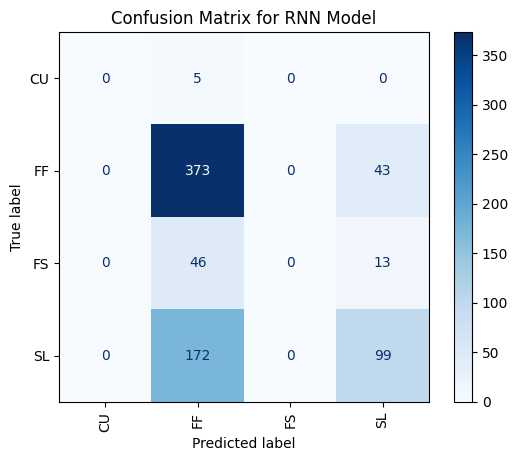

In [ ]:
# Display test loss, accuracy
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Testing Loss: {test_loss}")
print(f"Testing Accuracy: {test_accuracy}\n")


# Display confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix for RNN Model')
plt.show()

## 3.2 Two-Layer LSTM Model

In [ ]:
# Number of unique pitch types
num_classes = processed_y['pitch_type'].nunique()

# Build the model
model = Sequential([
    Masking(mask_value=0.0, input_shape=(X_train.shape[1], X_train.shape[2])),

    LSTM(64, return_sequences=True, dropout=0.4, recurrent_dropout=0.4),
    LayerNormalization(),

    LSTM(128, return_sequences=False, dropout=0.4, recurrent_dropout=0.4),
    LayerNormalization(),

    Dense(32, activation='relu'),
    Dropout(0.4),
    BatchNormalization(),

    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_17 (Masking)                 │ (None, 12, 226)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 12, 64)              │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_21               │ (None, 12, 64)              │             128 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_22               │ (None, 128)                 │             256 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 178,084 (695.64 KB)

 Trainable params: 178,020 (695.39 KB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
# Callbacks for training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

Epoch 1/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.2737 - loss: 1.7269 - val_accuracy: 0.4600 - val_loss: 1.1549 - learning_rate: 0.0010
Epoch 2/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.4636 - loss: 1.1775 - val_accuracy: 0.4920 - val_loss: 1.0235 - learning_rate: 0.0010
Epoch 3/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.5316 - loss: 1.0164 - val_accuracy: 0.4920 - val_loss: 0.9834 - learning_rate: 0.0010
Epoch 4/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.5754 - loss: 0.9440 - val_accuracy: 0.5040 - val_loss: 0.9795 - learning_rate: 0.0010
Epoch 5/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.5853 - loss: 0.9149 - val_accuracy: 0.4880 - val_loss: 0.9570 - learning_rate: 0.0010
Epoch 6/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.5831 - loss: 0.9221 - val_accuracy: 0.4920 - val_loss: 0.9598 - learning_rate: 0.0010
Epoch 7/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.6021 - los

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6365 - loss: 0.7630
Testing Loss: 0.7510771751403809
Testing Accuracy: 0.6458055973052979

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step


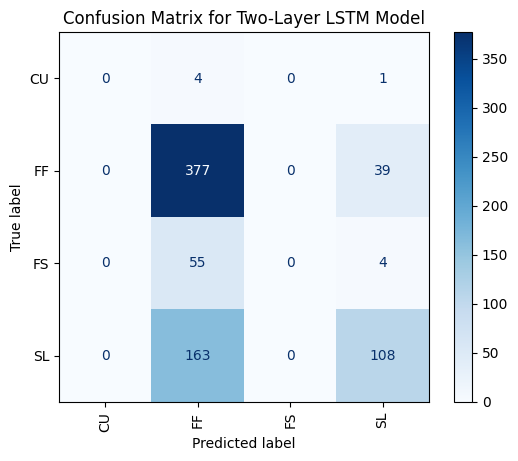

In [ ]:
# Display test loss, accuracy
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Testing Loss: {test_loss}")
print(f"Testing Accuracy: {test_accuracy}\n")


# Display confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix for Two-Layer LSTM Model')
plt.show()

 ## 3.3 Attention-Based LSTM Model

In [ ]:
# An Additive Attention Layer
class CustomAttention(Layer):
    def __init__(self):
        super(CustomAttention, self).__init__()
        self.score_dense = tf.keras.layers.Dense(1, activation='tanh')

    def call(self, lstm_outputs):
        """
        Input: lstm_outputs: (batch_size, sequence_length, hidden_dim)
        """
        # Compute attention scores (unnormalized)
        score = self.score_dense(lstm_outputs)
        score = tf.squeeze(score, axis=-1)
        # Compute attention weights
        alpha = tf.nn.softmax(score, axis=1)
        # Compute context vector as weighted sum of LSTM outputs
        context = tf.reduce_sum(lstm_outputs * tf.expand_dims(alpha, -1), axis=1)
        return context, alpha

In [ ]:
# Number of unique pitch types
num_classes = processed_y['pitch_type'].nunique()

# Build the model
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
masked = Masking(mask_value=0.0)(inputs)

lstm_1 = LSTM(64, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)(masked)
norm_1 = LayerNormalization()(lstm_1)

lstm_2 = LSTM(128, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)(norm_1)
norm_2 = LayerNormalization()(lstm_2)

attention_layer = CustomAttention()
context_vector, attention_weights = attention_layer(norm_2)

dense_1 = Dense(32, activation='relu')(context_vector)
dropout_1 = Dropout(0.25)(dense_1)
norm_3 = BatchNormalization()(dropout_1)

outputs = Dense(num_classes, activation='softmax')(norm_3)

model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'custom_attention_15' (of type CustomAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_33            │ (None, 12, 226)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_33 (NotEqual)   │ (None, 12, 226)        │              0 │ input_layer_33[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ masking_33 (Masking)      │ (None, 12, 226)        │              0 │ input_layer_33[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ any_33 (Any)              │ (None, 12)             │              0 │ not_equal_33[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_40 (LSTM)            │ (None, 12, 64)         │         74,496 │ masking_33[0][0],      │
│                           │                        │                │ any_33[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_53    │ (None, 12, 64)         │            128 │ lstm_40[0][0]          │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_41 (LSTM)            │ (None, 12, 128)        │         98,816 │ layer_normalization_5… │
│                           │                        │                │ any_33[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_54    │ (None, 12, 128)        │            256 │ lstm_41[0][0]          │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ custom_attention_15       │ [(None, 128), (None,   │            129 │ layer_normalization_5… │
│ (CustomAttention)         │ 12)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_82 (Dense)          │ (None, 32)             │          4,128 │ custom_attention_15[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_33 (Dropout)      │ (None, 32)             │              0 │ dense_82[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_33    │ (None, 32)             │            128 │ dropout_33[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_83 (Dense)          │ (None, 4)              │            132 │ batch_normalization_3… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 178,213 (696.14 KB)

 Trainable params: 178,149 (695.89 KB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
# Callbacks for training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

Epoch 1/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step - accuracy: 0.2968 - loss: 1.6282 - val_accuracy: 0.4720 - val_loss: 1.0971 - learning_rate: 0.0010
Epoch 2/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4468 - loss: 1.2249 - val_accuracy: 0.4840 - val_loss: 1.0576 - learning_rate: 0.0010
Epoch 3/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.5395 - loss: 1.0500 - val_accuracy: 0.4880 - val_loss: 1.0003 - learning_rate: 0.0010
Epoch 4/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.5452 - loss: 0.9673 - val_accuracy: 0.5080 - val_loss: 0.9515 - learning_rate: 0.0010
Epoch 5/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.5593 - loss: 0.9444 - val_accuracy: 0.5120 - val_loss: 0.9217 - learning_rate: 0.0010
Epoch 6/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.5855 - loss: 0.9092 - val_accuracy: 0.4960 - val_loss: 0.9208 - learning_rate: 0.0010
Epoch 7/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.5814 - loss:

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6541 - loss: 0.7120
Testing Loss: 0.6993920803070068
Testing Accuracy: 0.6697736382484436

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step


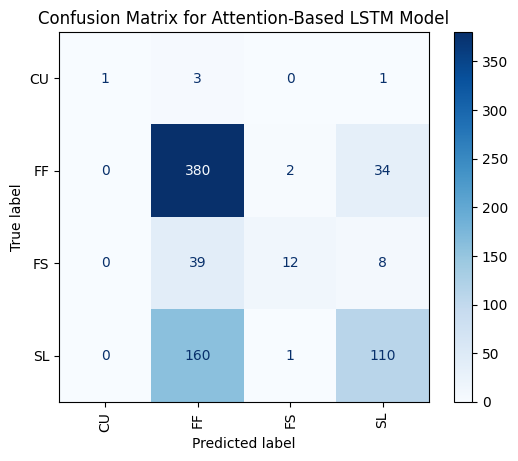

In [ ]:
# Display test loss, accuracy
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Testing Loss: {test_loss}")
print(f"Testing Accuracy: {test_accuracy}\n")


# Display confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix for Attention-Based LSTM Model')
plt.show()

## 3.4 RNN-Based Specialist Model

The specialist model consists of two models: "Normal" and "Specialized" models. Both models have a similar architecture to the RNN Model, however, the "Normal" model is trained on all sequences `X`, while the "Specialized" model is trained on hand-picked sequences that have outputs of less frequently thrown pitch types.

### 3.4.1 Create Special Dataset

Let's visualize the frequencies of each pitch type of this pitcher to decide how we want to define "less frequent".

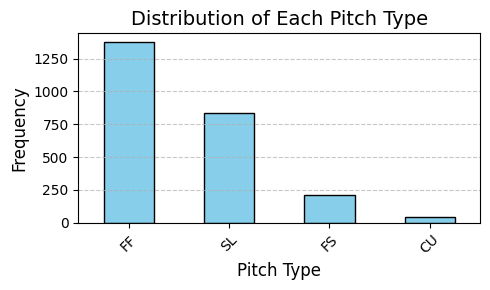

In [9]:
pitch_type_distribution = data['pitch_type'].value_counts()
plt.figure(figsize=(5, 3))
pitch_type_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribution of Each Pitch Type", fontsize=14)
plt.xlabel("Pitch Type", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

We'll start by picking out sequences that have outputs of less frequent pitch types. As we can see from the above graph, the top 2 most frequent pitch types dominant the dataset by a lot. Thus, we choose to exclude the top 2 most frequent pitch types from our special dataset `X_special`.

In [144]:
def nth_most_frequent(N):
    # N-th most frequent pitch type (N = 1, 2, 3, ...)
    nth_most_frequent_numeric = processed_y[output_feature].value_counts().index[N - 1]
    print(f"The {N}-th most frequent pitch type is: {y_label_encoder.inverse_transform([nth_most_frequent_numeric])[0]}")
    return nth_most_frequent_numeric


# Get sequences that end with less frequent pitch types
indice_special_y = np.where((y.flatten() != nth_most_frequent(1)) & (y.flatten() != nth_most_frequent(2)) )[0]
X_special = X[indice_special_y]
y_special = y[indice_special_y]
print(f"X_special shape: {X_special.shape}")
print(f"y_special shape: {y_special.shape}")

The 1-th most frequent pitch type is: FF
The 2-th most frequent pitch type is: SL
X_special shape: (429, 12, 226)
y_special shape: (429, 1)


Next, we'll split `X_special` into training, validation, and testing sets.

In [175]:
train_ratio = 0.6
val_ratio = 0.05
test_ratio = 0.35

# First, split into training and temp (validation + testing)
X_special_train, X_special_temp, y_special_train, y_special_temp = train_test_split(X_special, y_special, test_size=(1 - train_ratio), random_state=42)

# Then, split temp into validation and testing
val_test_ratio = test_ratio / (test_ratio + val_ratio)  # Adjust split ratio for remaining data
X_special_val, X_special_test, y_special_val, y_special_test = train_test_split(X_special_temp, y_special_temp, test_size=val_test_ratio, random_state=42)

# Print dataset sizes
print(f"Training set: {X_special_train.shape}, {y_special_train.shape}")
print(f"Validation set: {X_special_val.shape}, {y_special_val.shape}")
print(f"Testing set: {X_special_test.shape}, {y_special_test.shape}")

Training set: (257, 12, 226), (257, 1)
Validation set: (21, 12, 226), (21, 1)
Testing set: (151, 12, 226), (151, 1)


Finally, if all sequences end with less frequent pitch types, the specialist might become too extreme, so we mix in some sequences from the normal dataset `X` to get the final well-mixed dataset `X_combined`.

Note that the proportion here is an experimental result, we've tried many combinations and turns out this proportion works sufficiently well for our pitcher. You might want to try other proportions for other pitchers.

In [186]:
# Get sequences from X to mix in
indices_train = np.random.choice(X_train.shape[0], 20, replace=False)
indices_val= np.random.choice(X_val.shape[0], 40, replace=False)
indices_test = np.random.choice(X_test.shape[0], 320, replace=False)

X_train_c= X_train[indices_train]
y_train_c = y_train[indices_train]
X_val_c = X_val[indices_val]
y_val_c = y_val[indices_val]
X_test_c = X_test[indices_test]
y_test_c = y_test[indices_test]

# Combine X_train and X_special_train
X_combined_train = np.concatenate((X_train_c, X_special_train), axis=0)
y_combined_train = np.concatenate((y_train_c, y_special_train), axis=0)
X_combined_val = np.concatenate((X_val_c, X_special_val), axis=0)
y_combined_val = np.concatenate((y_val_c, y_special_val), axis=0)
X_combined_test = np.concatenate((X_test_c, X_special_test), axis=0)
y_combined_test = np.concatenate((y_test_c, y_special_test), axis=0)

print("Combined Training set: ", X_combined_train.shape, y_combined_train.shape)
print("Combined Validation set: ", X_combined_val.shape, y_combined_val.shape)
print("Combined Testing set: ", X_combined_test.shape, y_combined_test.shape)

Combined Training set:  (277, 12, 226) (277, 1)
Combined Validation set:  (61, 12, 226) (61, 1)
Combined Testing set:  (471, 12, 226) (471, 1)


### 3.4.2 Model Training

We'll train the Normal Model using our usual dataset `X`.

In [187]:
# Number of unique pitch types
num_classes = processed_y[output_feature].nunique()

# Build the model
model = Sequential([
    Masking(mask_value=0.0, input_shape=(X_train.shape[1], X_train.shape[2])),

    SimpleRNN(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3),
    LayerNormalization(),

    Dense(32, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),

    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_38 (Masking)                 │ (None, 12, 226)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_38 (SimpleRNN)            │ (None, 64)                  │          18,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_38               │ (None, 64)                  │             128 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_76 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_77 (Dense)                     │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,092 (82.39 KB)

 Trainable params: 21,028 (82.14 KB)

 Non-trainable params: 64 (256.00 B)

In [188]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=32,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

Epoch 1/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.2769 - loss: 1.6574 - val_accuracy: 0.5000 - val_loss: 1.1570 - learning_rate: 0.0010
Epoch 2/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4502 - loss: 1.2125 - val_accuracy: 0.5400 - val_loss: 1.0263 - learning_rate: 0.0010
Epoch 3/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5648 - loss: 1.0158 - val_accuracy: 0.5640 - val_loss: 0.9713 - learning_rate: 0.0010
Epoch 4/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5782 - loss: 0.9327 - val_accuracy: 0.5480 - val_loss: 0.9327 - learning_rate: 0.0010
Epoch 5/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5849 - loss: 0.9172 - val_accuracy: 0.5400 - val_loss: 0.9252 - learning_rate: 0.0010
Epoch 6/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6092 - loss: 0.8751 - val_accuracy: 0.5720 - val_loss: 0.9130 - learning_rate: 0.0010
Epoch 7/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6057 - loss: 0.8

Next up, we'll train the Specialized Model using the mixed dataset `X_combined`.

In [189]:
# Number of unique pitch types
num_classes = processed_y[output_feature].nunique()

# Build the model_special
model_special = Sequential([
    Masking(mask_value=0.0, input_shape=(X_combined_train.shape[1], X_combined_train.shape[2])),

    SimpleRNN(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3),
    LayerNormalization(),

    Dense(32, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),

    Dense(num_classes, activation='softmax')
])

# Compile the model_special
model_special.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_38 (Masking)                 │ (None, 12, 226)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_38 (SimpleRNN)            │ (None, 64)                  │          18,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_38               │ (None, 64)                  │             128 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_76 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_77 (Dense)                     │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,150 (246.68 KB)

 Trainable params: 21,028 (82.14 KB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 42,058 (164.29 KB)

In [190]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

history = model_special.fit(
    X_combined_train, y_combined_train,
    validation_data=(X_combined_val, y_combined_val),
    epochs=50,
    batch_size=32,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.2350 - loss: 1.7771 - val_accuracy: 0.2787 - val_loss: 1.4042 - learning_rate: 0.0010
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2497 - loss: 1.6769 - val_accuracy: 0.2951 - val_loss: 1.3727 - learning_rate: 0.0010
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2636 - loss: 1.6338 - val_accuracy: 0.3115 - val_loss: 1.3471 - learning_rate: 0.0010
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3674 - loss: 1.4827 - val_accuracy: 0.4262 - val_loss: 1.3282 - learning_rate: 0.0010
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3366 - loss: 1.4184 - val_accuracy: 0.4590 - val_loss: 1.3132 - learning_rate: 0.0010
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3387 - loss: 1.3688 - val_accuracy: 0.4426 - val_loss: 1.3003 - learning_rate: 0.0010
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4273 - loss: 1.3223 - val_accuracy: 0.4754 

After training the two models, we will determine a good weight assignment to the outputs of the two models using the validation set.

Our method is to simply loop over all possible combinations of (rate, 1-rate), where rate's value is taken from a predefined range. We'll also print out all confusion matrices for the different combinations.

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


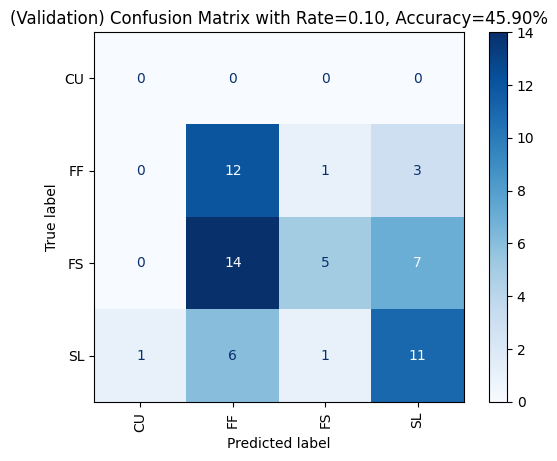

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


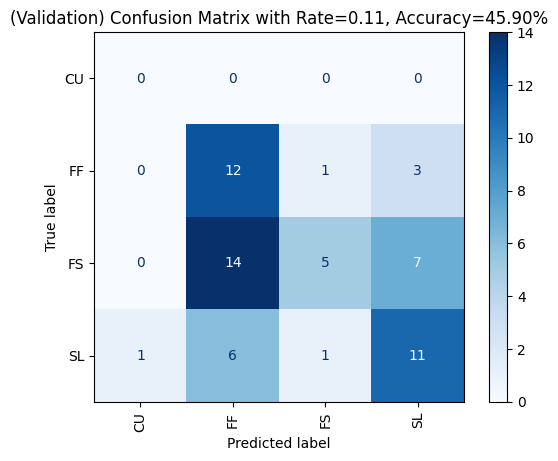

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


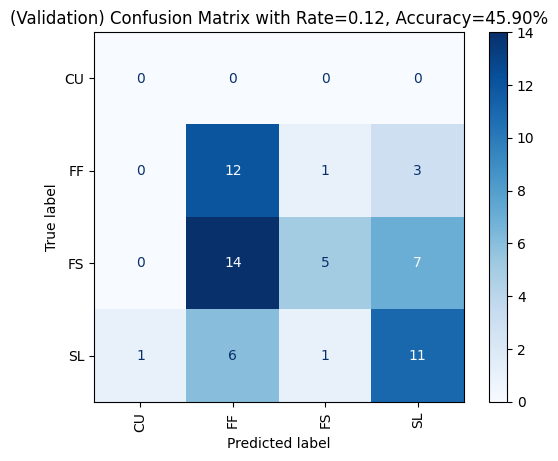

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


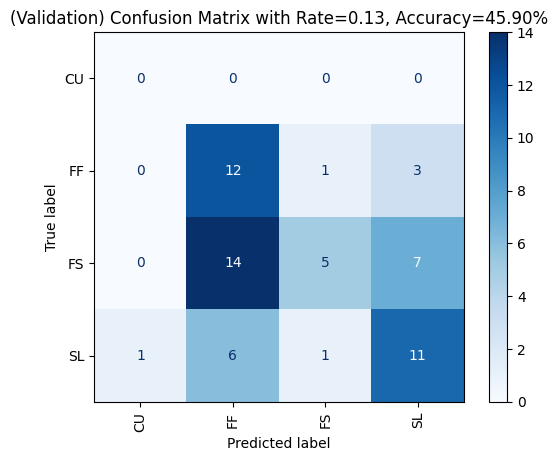

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


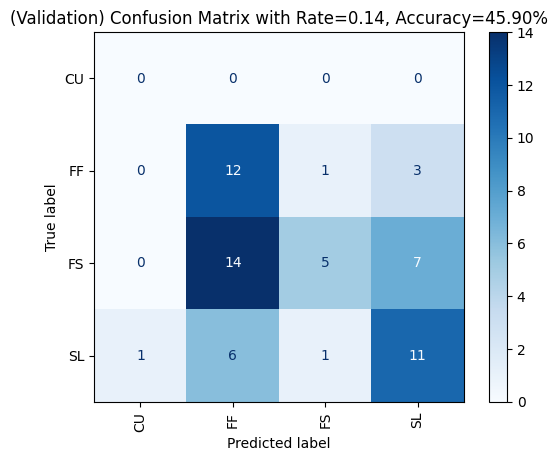

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


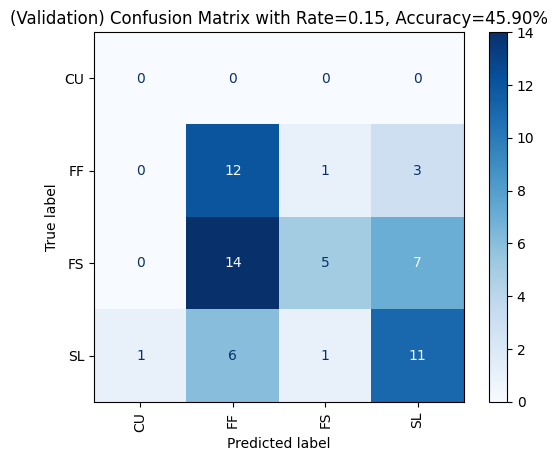

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


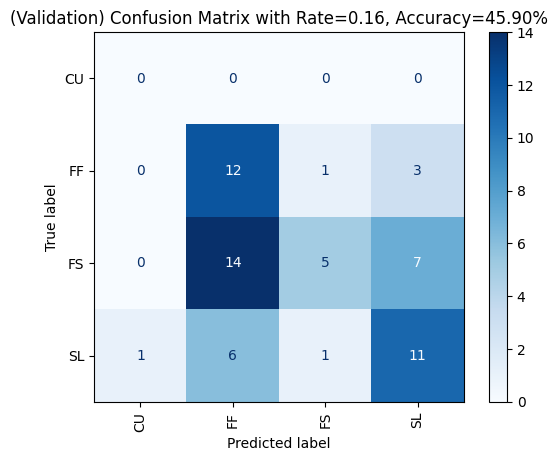

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


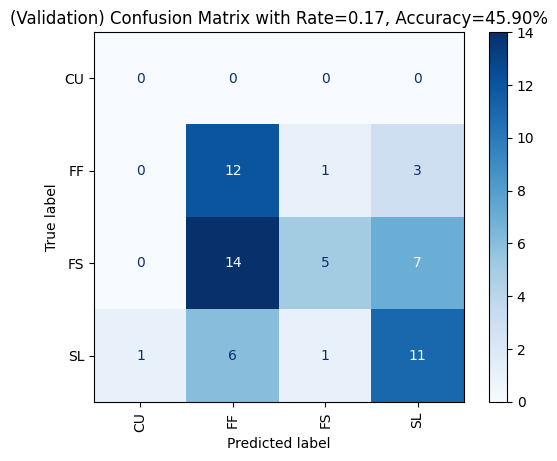

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


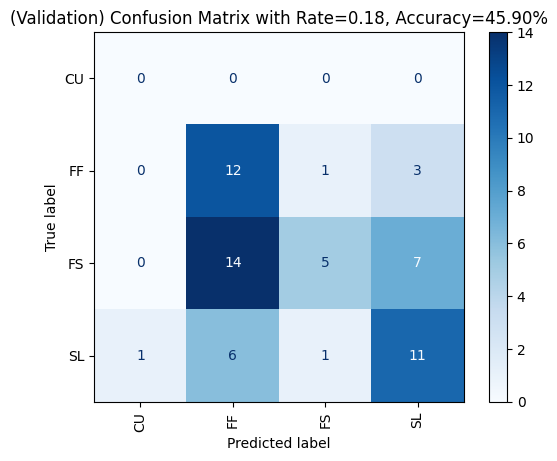

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


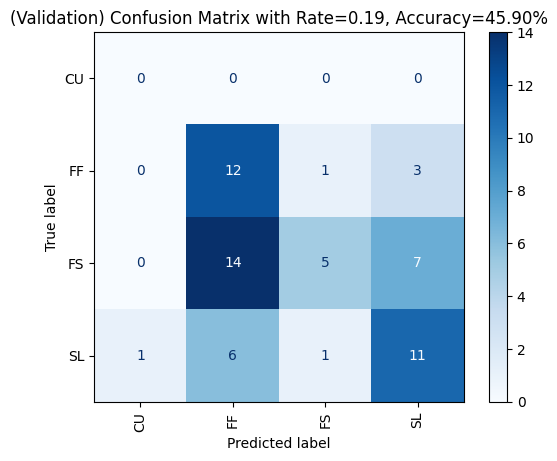

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


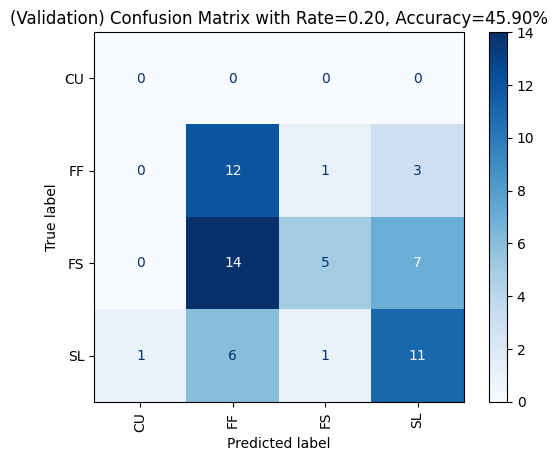

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


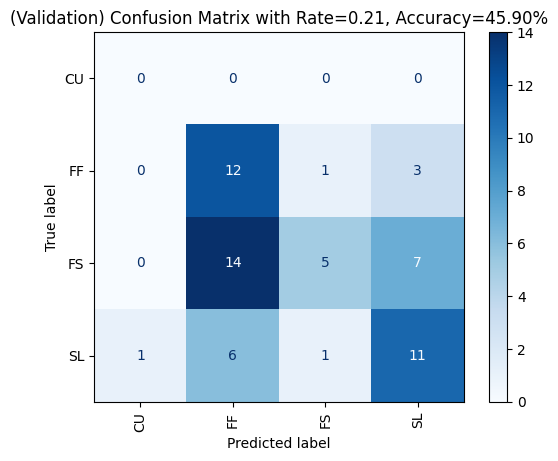

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


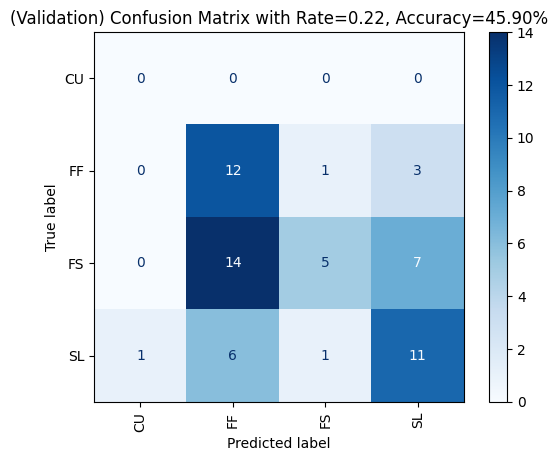

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


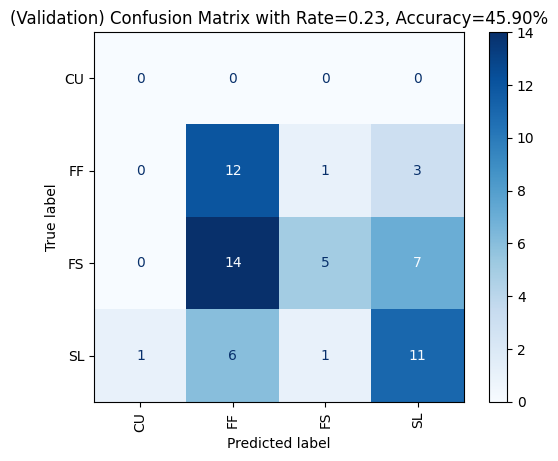

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


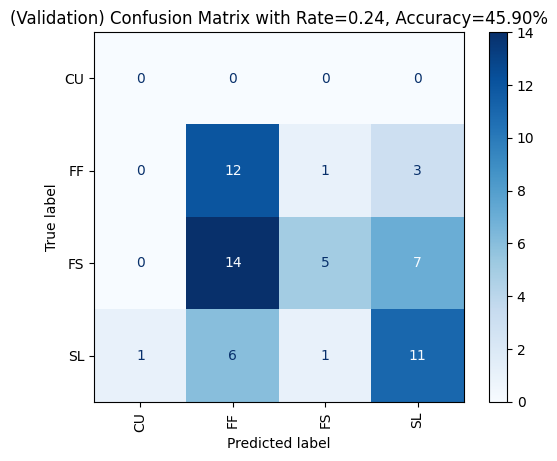

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


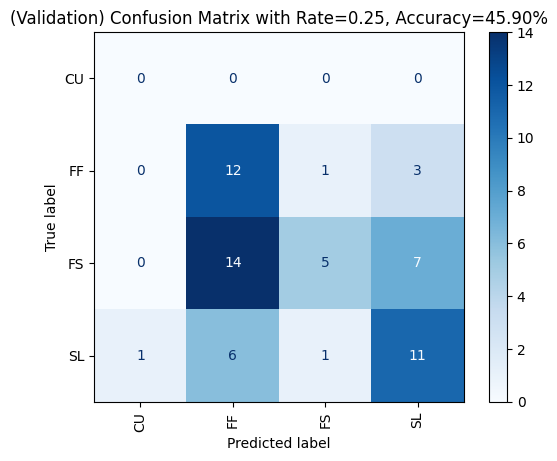

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


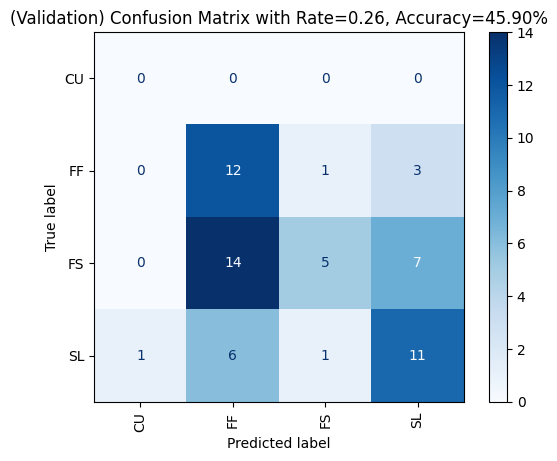

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


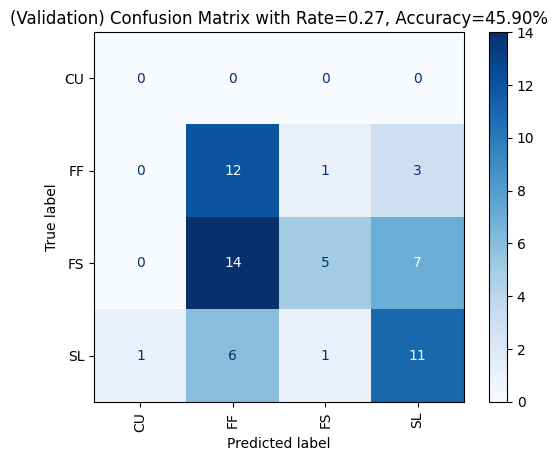

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


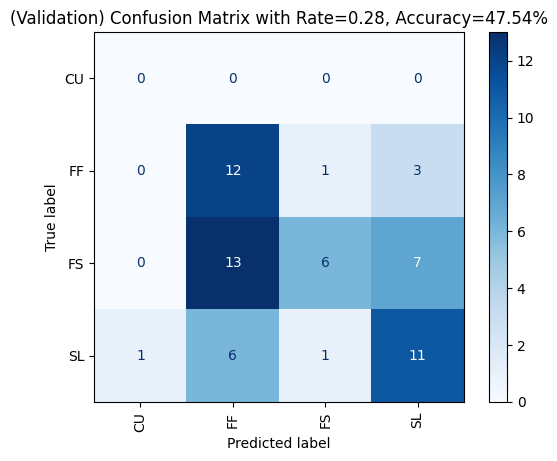

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


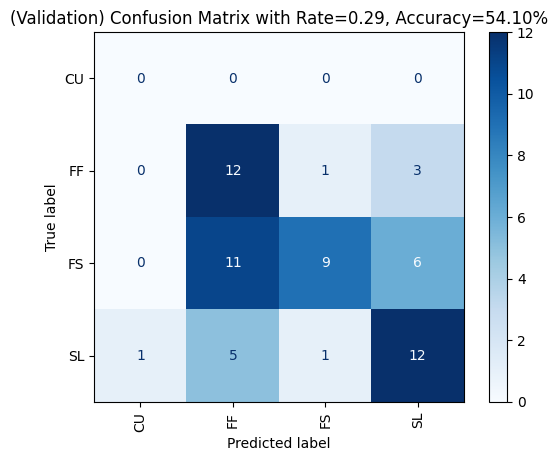

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


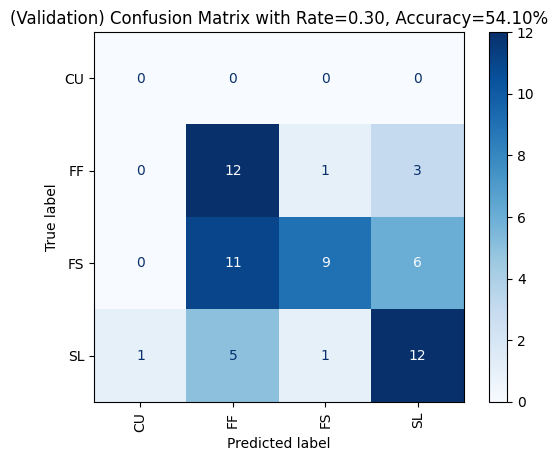

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


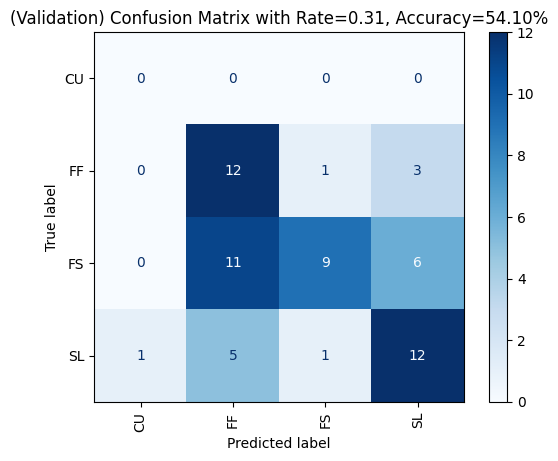

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


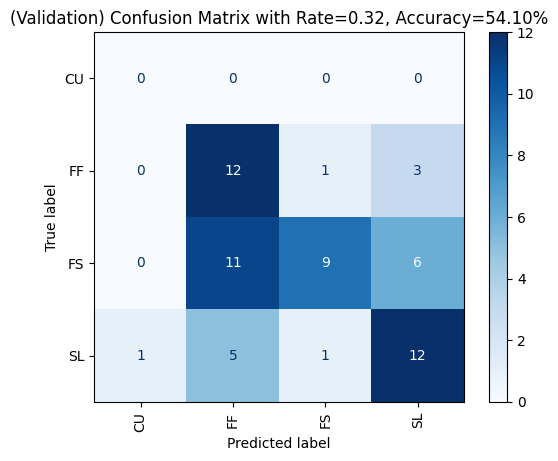

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


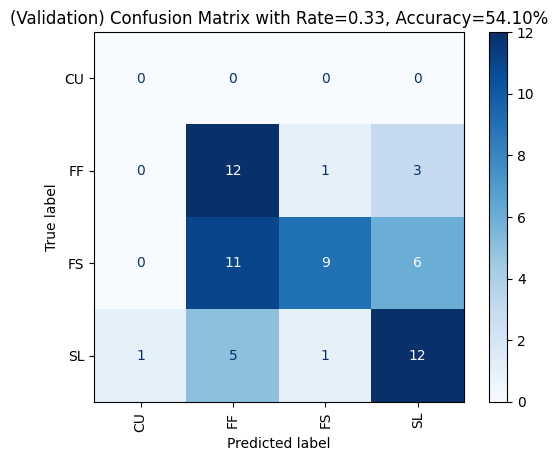

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


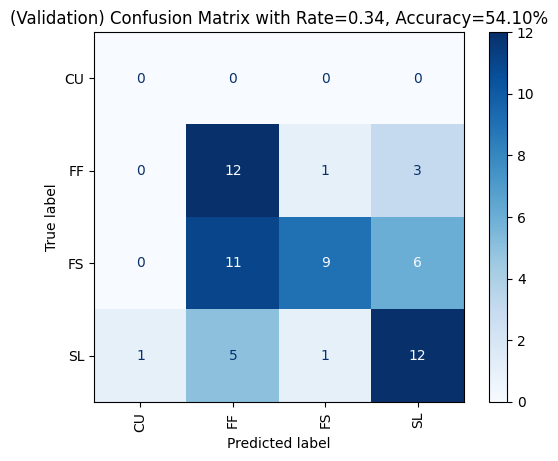

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


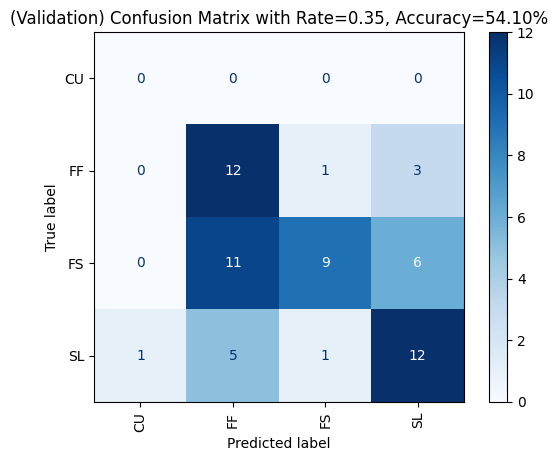

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


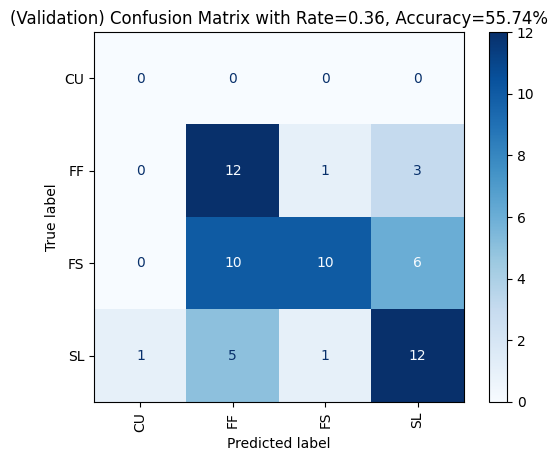

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


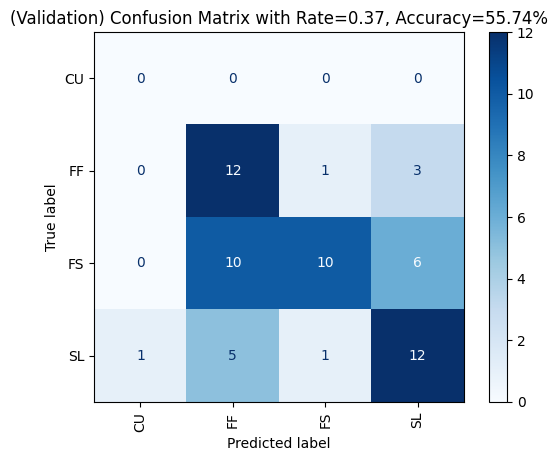

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


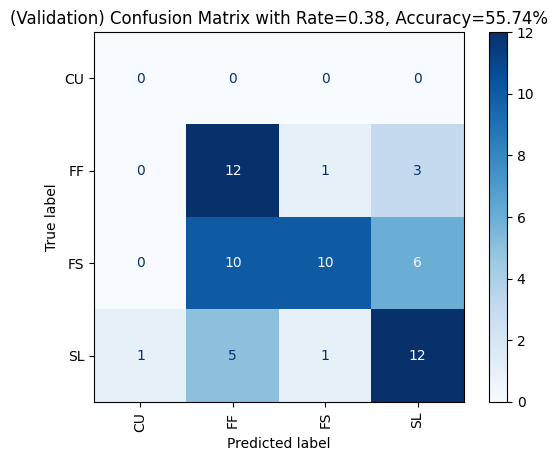

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


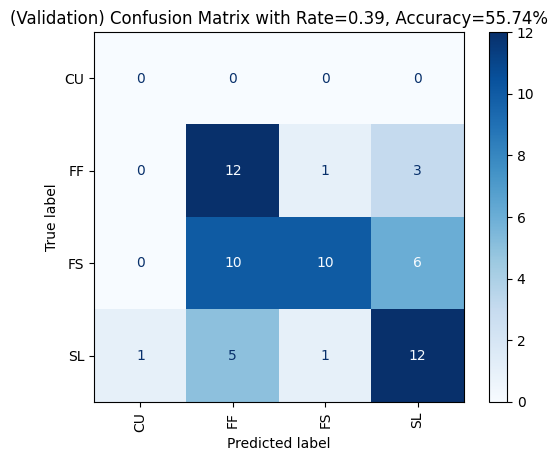

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


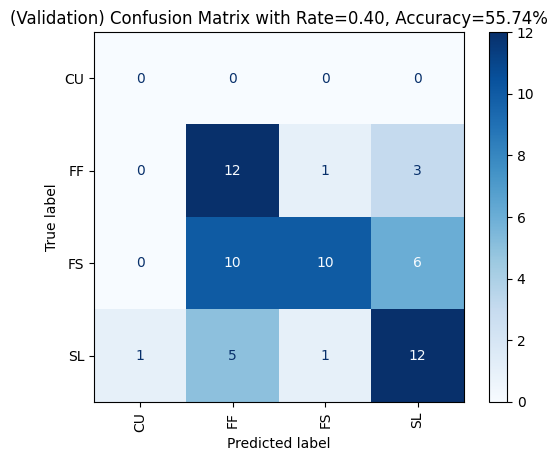

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


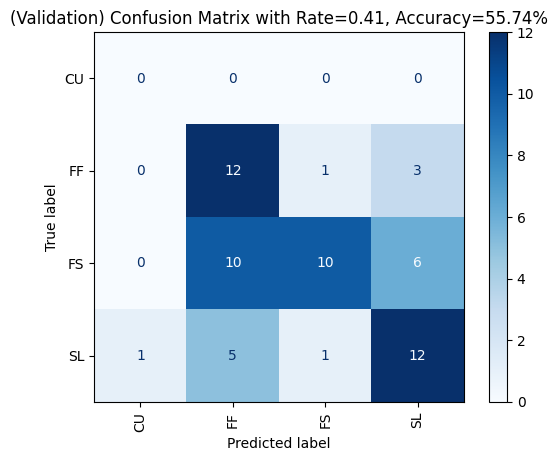

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


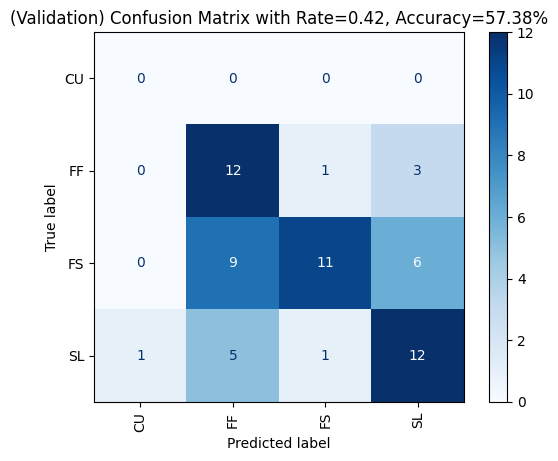

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


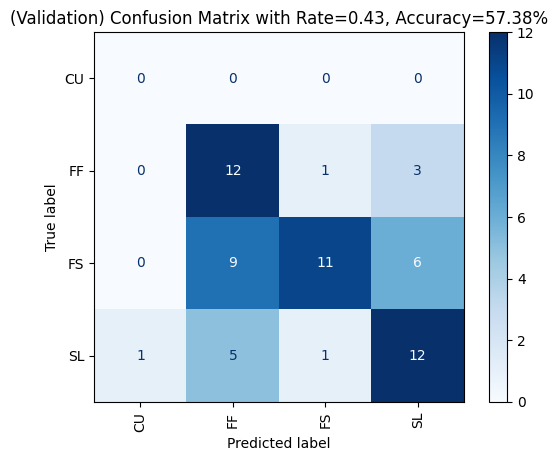

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


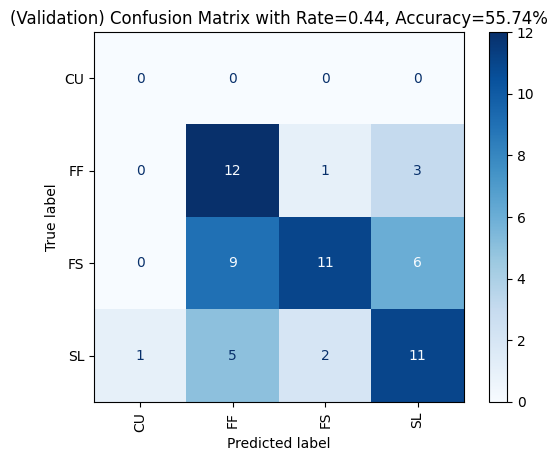

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


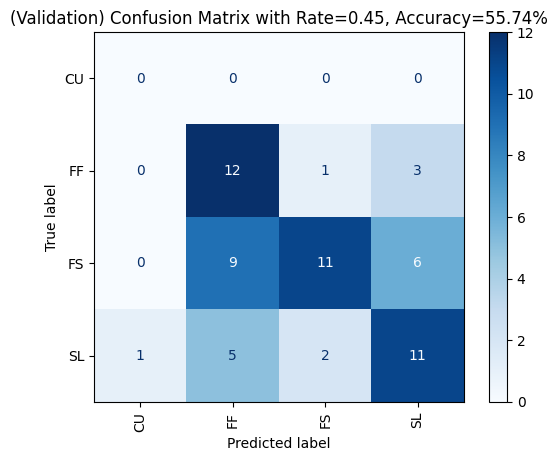

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


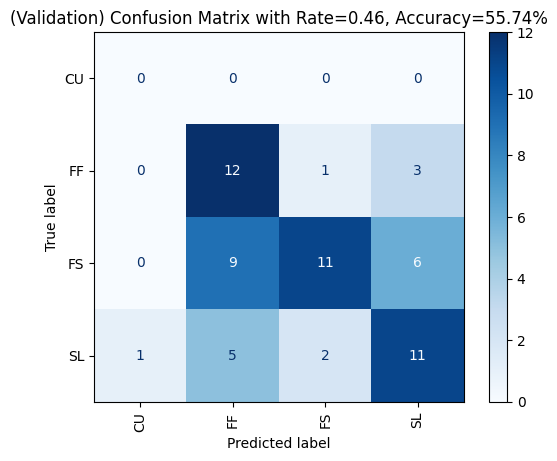

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


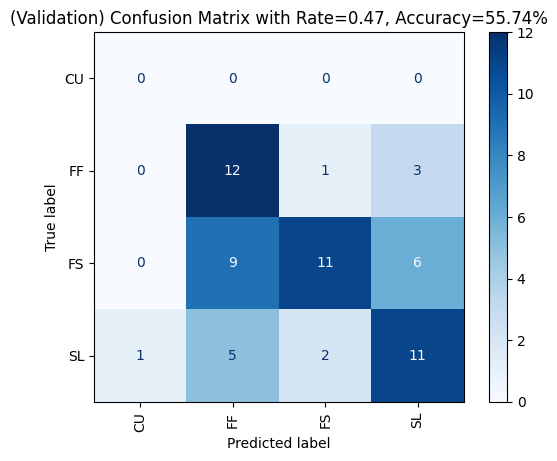

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


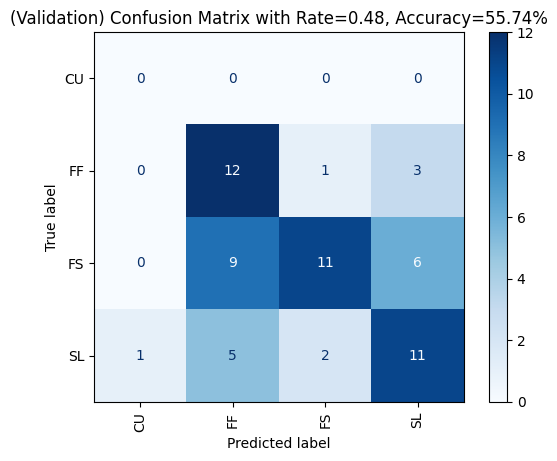

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


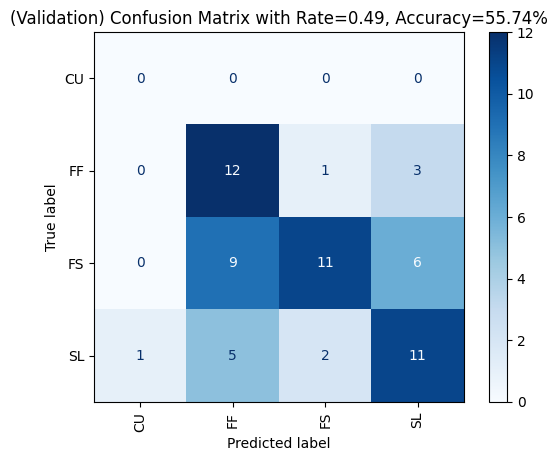


========= FINAL BEST =========
(Validation) Best Rate: 0.42
(Validation) Best Accuracy: 57.38%


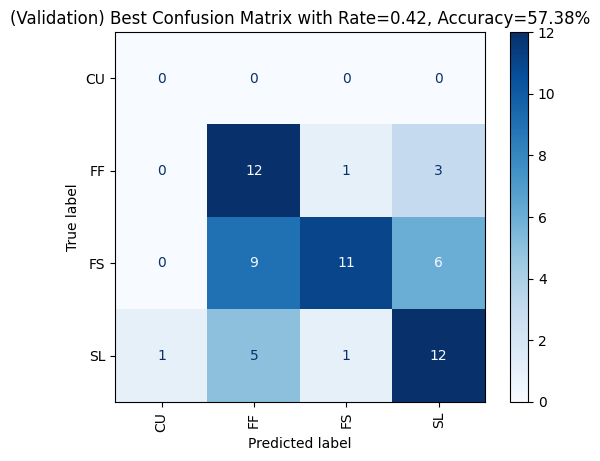

In [191]:
best_rate = 0
best_accuracy = 0
best_cm = None

rates = np.arange(0.1, 0.5, 0.01)
for rate in rates:
    y_pred = rate * model_special.predict(X_combined_val) + (1 - rate) * model.predict(X_combined_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_combined_val, y_pred_classes, labels=np.arange(num_classes))
    accuracy = accuracy_score(y_combined_val, y_pred_classes)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title(f'(Validation) Confusion Matrix with Rate={rate:.2f}, Accuracy={accuracy:.2%}')
    plt.show()

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_rate = rate
        best_cm = cm


# Print best rate for validation set
print("\n========= FINAL BEST =========")
print(f"(Validation) Best Rate: {best_rate:.2f}")
print(f"(Validation) Best Accuracy: {best_accuracy:.2%}")
# Print its confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=best_cm, display_labels=y_label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title(f'(Validation) Best Confusion Matrix with Rate={best_rate:.2f}, Accuracy={best_accuracy:.2%}')
plt.show()

After all that hardwork, let's visualize its performance on the testing dataset!

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
========= SPECIALIZED MODEL PERFORMANCE ON TESTING DATASET =========
Rate: 0.42
Testing Accuracy: 63.69%


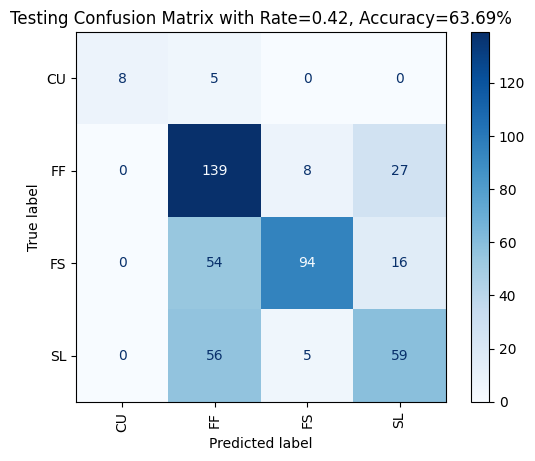

In [192]:
y_pred = best_rate * model_special.predict(X_combined_test) + (1 - best_rate) * model.predict(X_combined_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_combined_test, y_pred_classes, labels=np.arange(num_classes))
accuracy = accuracy_score(y_combined_test, y_pred_classes)

print("========= SPECIALIZED MODEL PERFORMANCE ON TESTING DATASET =========")
print(f"Rate: {best_rate:.2f}")
print(f"Testing Accuracy: {accuracy:.2%}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title(f'Testing Confusion Matrix with Rate={best_rate:.2f}, Accuracy={accuracy:.2%}')
plt.show()

For comparison, let's also print the confusion matrix when `rate` is set to 0, which is just the Normal Model (i.e., our baseline RNN Model).

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
========= BASELINE RNN MODEL PERFORMANCE ON TESTING DATASET =========
Accuracy: 57.96%


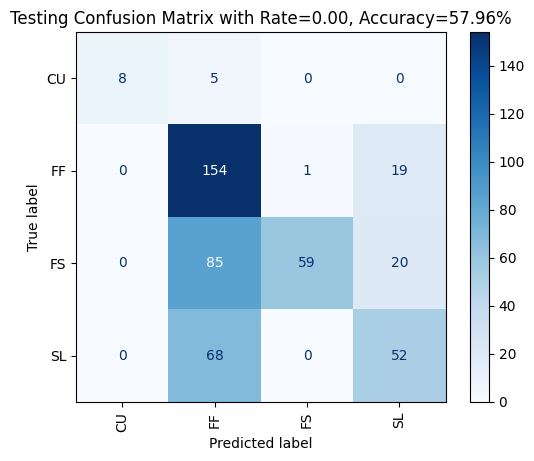

In [193]:
rate = 0
y_pred = rate * model_special.predict(X_combined_test) + (1 - rate) * model.predict(X_combined_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_combined_test, y_pred_classes, labels=np.arange(num_classes))
accuracy = accuracy_score(y_combined_test, y_pred_classes)

print("========= BASELINE RNN MODEL PERFORMANCE ON TESTING DATASET =========")
print(f"Accuracy: {accuracy:.2%}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title(f'Testing Confusion Matrix with Rate={rate:.2f}, Accuracy={accuracy:.2%}')
plt.show()